# ResNet using PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
# Using PyTorch Accelaration using Apple Silicon 'MPS' GPU
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

## Residual Block:
A Residual Block is responsible for learning and capturing features from the input data.

```
if stride != 1 or in_channels != out_channels:
    self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
    )
else:
    self.shortcut = nn.Identity()

```

This block of code is the skip connection

In [3]:
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        # Skip Connection
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

## The ResNet Model:
This version is ResNet-18. Not exactly, but while model defining, we will pass # Blocks as [2,2,2,2]

In [4]:
# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Load the MNIST dataset

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

## Create the ResNet model

ResNet-18 requires the number of blocks in each stage to be defined as [2, 2, 2, 2]

In [6]:
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)

## Define the loss function and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Model Training

In [8]:
num_epochs = 10
total_step = len(train_loader)

for epoch in range(num_epochs):
    progress_bar = tqdm(enumerate(train_loader), total=total_step, leave=False)
    for i, (images, labels) in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            progress_bar.set_description(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}")

## Model Testing

In [9]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    predictions = []
    targets = []

    progress_bar = tqdm(test_loader, leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

        accuracy = 100 * correct / total
        progress_bar.set_description(f"Test Accuracy: {accuracy:.2f}%")

print(f"Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%")

Test Accuracy of the model on the 10000 test images: 99.26%


## Actual Vs Predicted


Actual and Predicted Labels:
----------------------------------


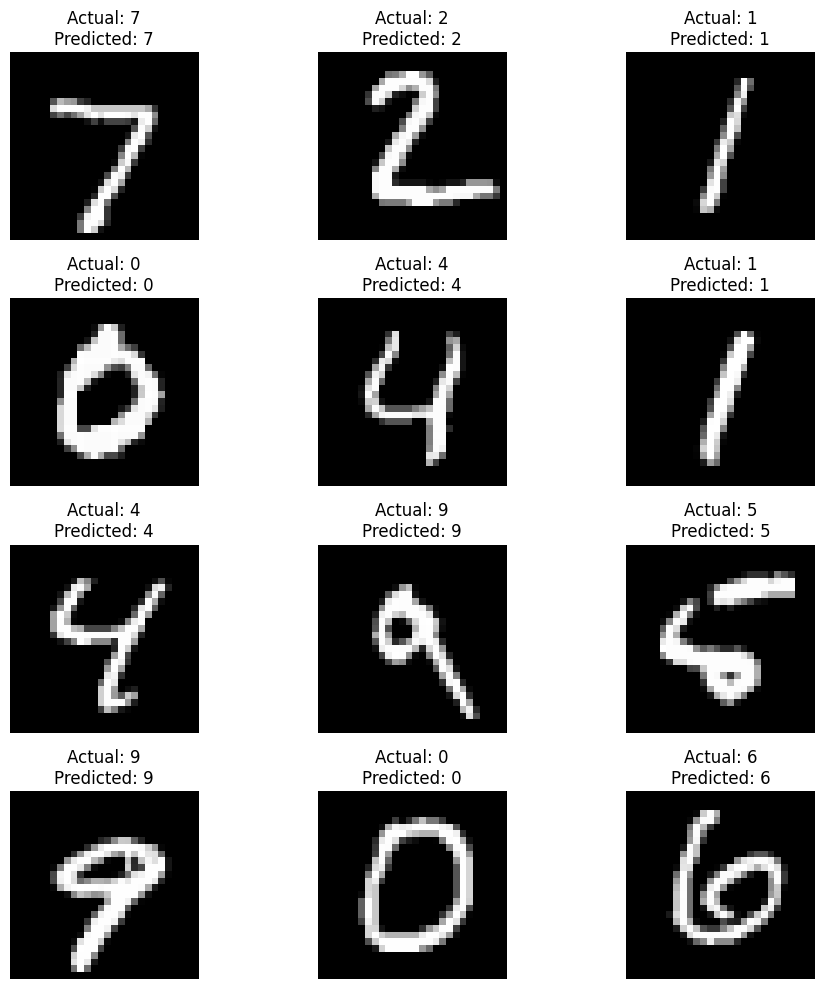

In [11]:
import matplotlib.pyplot as plt

# Print the actual and predicted labels for 12 test samples
print("\nActual and Predicted Labels:")
print("----------------------------------")
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    image, actual_label = test_dataset[i]
    predicted_label = predictions[i]
    image = image.squeeze().numpy()
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


## Classification Report and Confusion Matrix

Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



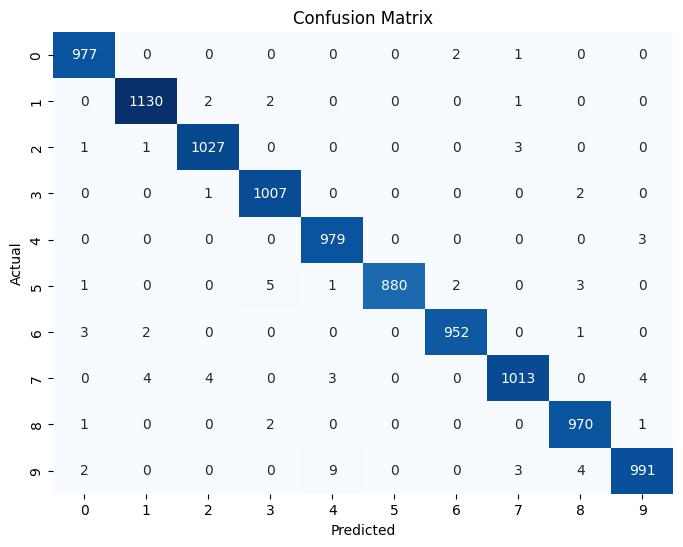

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Convert the predictions and targets to NumPy arrays
predictions = np.array(predictions)
targets = np.array(targets)

# Print the classification report
print("Classification Report:")
print("----------------------")
print(classification_report(targets, predictions))

# Generate and plot the confusion matrix
cm = confusion_matrix(targets, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()